In [1]:
from fit import *
import matplotlib.pyplot as plt
%matplotlib widget
from utils import plot_event, plot_generator, get_data_files, preceding_noise_files
from counter_config import CounterConfig, init_config

First set up the MC configuration, i.e. the data part for which we're simulating data.

In [2]:
# data_date_and_time = '20190504034237'
# data_files = get_data_files(data_date_and_time)
# noise_files = [preceding_noise_file(f) for f in data_files]
# cfg = CounterConfig(data_files, noise_files)
data_date_and_time = '20200818040605'
cfg = init_config(data_date_and_time)
ckv = GetCkv(cfg)

Now let's simulate an event with given shower parameters.

In [3]:
# pars = [6.479052e+02,1.705156e+06,5.890362e-01,2.461860e+00, 437., -660.,-29.0,0,70,0.]
pars = [500.,2.e6,np.deg2rad(40.),np.deg2rad(315.), 450., -660.,-29,0,70,0.]
ev = BasicParams.get_event(pars)
pe = ProcessEvents(cfg, frozen_noise=True)
real_nfits = pe.gen_nfits_from_event(ev)
print(ev)

Event(E=1538461538461538.5, Xmax=500.0, Nmax=2000000.0, zenith=0.6981317007977318, azimuth=5.497787143782138, corex=450.0, corey=-660.0, corez=-29, X0=0, Lambda=70)


We now have fitted NICHE waveforms, so we can estimate the core position with a tyro fit, and perform a plane fit to estimate the shower direction. We then compile this info into inital guesses to supply to the minimizer.

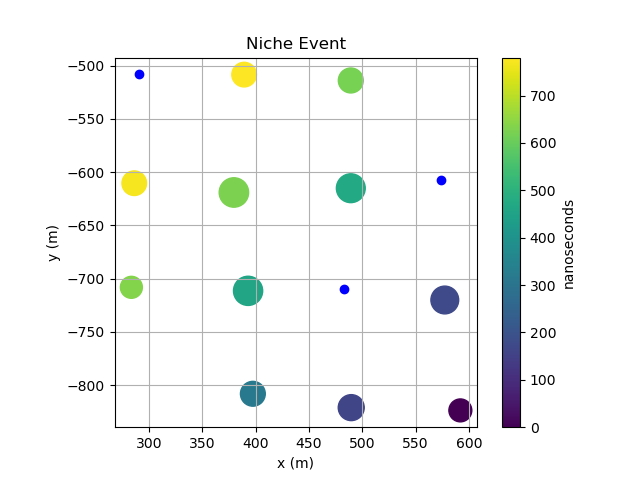

In [4]:
ty = tyro(real_nfits)
pf = NichePlane(real_nfits)
plot_event(ty)

In [5]:
pf

20240717164959.000025520
bardeen bell curie einstein feynman meitner newton noether rossi rubin rutherford 
nx =  0.4389 ny = -0.4516 z0 =  -2.2
  +/- 0.0003   +/- 0.0003   +/-  0.0
  ( 1.05e-07 -3.41e-09  2.87e-06)
  (-3.41e-09  8.61e-08 -6.59e-07)
  ( 2.87e-06 -6.59e-07  8.64e-04)
th =  0.6813 ph =  5.4835

In [6]:
guess = make_guess(ty, pf,cfg)
# for i,p in enumerate(guess):
#     guess[i].value = pars[i]
[print(p) for p in guess];

FitParam(name='xmax', value=500.0, limits=(400.0, 800.0), error=50.0, fixed=False)
FitParam(name='nmax', value=1000000.0, limits=(10000.0, 100000000.0), error=100000.0, fixed=False)
FitParam(name='zenith', value=0.6812587098584355, limits=(0.0, 0.7812587098584355), error=0.017453292519943295, fixed=False)
FitParam(name='azimuth', value=5.483487573088021, limits=(5.383487573088021, 5.5834875730880205), error=0.017453292519943295, fixed=False)
FitParam(name='corex', value=456.35548583194844, limits=(379.5, 577.4), error=5.0, fixed=False)
FitParam(name='corey', value=-665.1956923763145, limits=(-720.0, -615.1), error=5.0, fixed=False)
FitParam(name='corez', value=-29.0, limits=(-29.0, -29.0), error=1.0, fixed=True)
FitParam(name='x0', value=0.0, limits=(0, 0), error=1, fixed=True)
FitParam(name='lambda', value=70.0, limits=(60.0, 80.0), error=1, fixed=True)
FitParam(name='t_offset', value=0.0, limits=(-450.0, 450.0), error=10.0, fixed=False)


Fitting for the log of xmax and nmax rather than the values themselves results in a better fit, so we use the BasicParams mapper to go between the fitted parameters and the real ones.

In [7]:
guess = BasicParams.adjust_guess(guess)
# guess = pars

Now we can begin the fit procedure, starting by fitting the peaktimes for the shower angles.

Now with a good estimate for the angles, we can fit the pulse widths to estimate xmax.

In [8]:
pt = PeakTimes(real_nfits, BasicParams, cfg)
pt.target_parameters = ['zenith','azimuth']
m = init_minuit(pt, guess)
m.simplex(ncall=40)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 12.99 (χ²/ndof = 1.4)      │              Nfcn = 38               │
│ EDM = 0.109 (Goal: 0.1)          │           time = 13.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    500    │    50     │            │            │   400   │   800   │  yes  │
│ 1 │ nmax     │   1.0e6   │   0.1e6   │            │            │  10000  │  1e+08  │  yes  │
│ 2 │ zenith   │ 695.91e-3 │  0.17e-3  │            │            │    0    │0.781259 │       │
│ 3 │ azimuth  │  5.4974   │  0.0004   │            │            │ 5.38349 │ 5.58349 │       │
│ 4 │ corex    │    456    │     5     │            │            │  379.5  │  577.4  │  yes  │
│ 5 │ corey    │   -665    │     5     │            │            │  -720   │ -615.1  │  yes  │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │   60    │   80    │  yes  │
│ 9 │ t_offset │     0     │    10     │            │            │  -450   │   450   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [9]:
tpguess = update_guess(m)
pw = PulseWidth(real_nfits, BasicParams, cfg)
pw.target_parameters = ['xmax']
m = init_minuit(pw, tpguess)
m.simplex(ncall=40)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.445 (χ²/ndof = 0.7)      │              Nfcn = 11               │
│ EDM = 0.00398 (Goal: 0.1)        │            time = 4.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    490    │    50     │            │            │   400   │   800   │       │
│ 1 │ nmax     │   1.0e6   │   0.1e6   │            │            │  10000  │  1e+08  │  yes  │
│ 2 │ zenith   │ 695.91e-3 │  0.17e-3  │            │            │    0    │0.781259 │  yes  │
│ 3 │ azimuth  │  5.4974   │  0.0004   │            │            │ 5.38349 │ 5.58349 │  yes  │
│ 4 │ corex    │    456    │     5     │            │            │  379.5  │  577.4  │  yes  │
│ 5 │ corey    │   -665    │     5     │            │            │  -720   │ -615.1  │  yes  │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │   60    │   80    │  yes  │
│ 9 │ t_offset │     0     │    10     │            │            │  -450   │   450   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now, with a good estimate for log(xmax), we can fit the integrated pulse areas for nmax.

In [10]:
xmaxguess = update_guess(m)
pa = PulseArea(real_nfits, BasicParams, cfg)
pa.target_parameters = ['nmax']
m = init_minuit(pa, xmaxguess)
m.simplex(ncall=20)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 11.96 (χ²/ndof = 1.2)      │              Nfcn = 20               │
│ EDM = 0.0241 (Goal: 0.1)         │            time = 8.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    490    │    50     │            │            │   400   │   800   │  yes  │
│ 1 │ nmax     │  2.14e6   │  0.05e6   │            │            │  10000  │  1e+08  │       │
│ 2 │ zenith   │ 695.91e-3 │  0.17e-3  │            │            │    0    │0.781259 │  yes  │
│ 3 │ azimuth  │  5.4974   │  0.0004   │            │            │ 5.38349 │ 5.58349 │  yes  │
│ 4 │ corex    │    456    │     5     │            │            │  379.5  │  577.4  │  yes  │
│ 5 │ corey    │   -665    │     5     │            │            │  -720   │ -615.1  │  yes  │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │   60    │   80    │  yes  │
│ 9 │ t_offset │     0     │    10     │            │            │  -450   │   450   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now, with these values in the ballpark, we can simultaneously minimize both the shower profile and core position by fitting the normalized pulse areas.

In [11]:
nmaxguess = update_guess(m)
pa = NormalizedPulseArea(real_nfits, BasicParams, cfg)
pa.target_parameters = ['xmax','nmax','corex','corey']
m = init_minuit(pa, nmaxguess)
m.simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.295 (χ²/ndof = 0.5)      │              Nfcn = 108              │
│ EDM = 0.13 (Goal: 0.1)           │           time = 43.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    520    │     5     │            │            │   400   │   800   │       │
│ 1 │ nmax     │  1.922e6  │  0.032e6  │            │            │  10000  │  1e+08  │       │
│ 2 │ zenith   │ 695.91e-3 │  0.17e-3  │            │            │    0    │0.781259 │  yes  │
│ 3 │ azimuth  │  5.4974   │  0.0004   │            │            │ 5.38349 │ 5.58349 │  yes  │
│ 4 │ corex    │    451    │     4     │            │            │  379.5  │  577.4  │       │
│ 5 │ corey    │  -663.9   │    0.5    │            │            │  -720   │ -615.1  │       │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │   60    │   80    │  yes  │
│ 9 │ t_offset │     0     │    10     │            │            │  -450   │   450   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now that we're reasonably close to the minimum, we can zero in on it by freeing all the parameters simultaneously.

In [12]:
guess = update_guess(m)
at = AllTunka(real_nfits, BasicParams, cfg)
at.target_parameters = ['t_offset']
m = init_minuit(at, guess)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 90.92 (χ²/ndof = 2.1)      │              Nfcn = 167              │
│ EDM = 1.85e-06 (Goal: 0.0002)    │           time = 69.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    520    │     5     │            │            │   400   │   800   │  yes  │
│ 1 │ nmax     │  1.922e6  │  0.032e6  │            │            │  10000  │  1e+08  │  yes  │
│ 2 │ zenith   │ 695.91e-3 │  0.17e-3  │            │            │    0    │0.781259 │  yes  │
│ 3 │ azimuth  │  5.4974   │  0.0004   │            │            │ 5.38349 │ 5.58349 │  yes  │
│ 4 │ corex    │    451    │     4     │            │            │  379.5  │  577.4  │  yes  │
│ 5 │ corey    │  -663.9   │    0.5    │            │            │  -720   │ -615.1  │  yes  │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │   60    │   80    │  yes  │
│ 9 │ t_offset │ -214.6875 │  0.0015   │            │            │  -450   │   450   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│          │     xmax     nmax   zenith  azimuth    corex    corey    corez       x0   lambda t_offset │
├──────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│     xmax │        0        0        0        0        0        0        0        0        0        0 │
│     nmax │        0        0        0        0        0        0        0        0        0        0 │
│   zenith │        0        0        0        0        0        0        0        0        0        0 │
│  azimuth │        0        0        0        0        0        0        0        0        0        0 │
│    corex │        0        0        0        0        0        0        0        0        0        0 │
│    corey │        0        0        0        0        0        0        0        0        0        0 │
│    corez │        0        0        0        0        0        0        0        0        0        0 │
│       x0 │        0        0        0        0        0        0        0        0        0        0 │
│   lambda │        0        0        0        0        0        0        0        0        0        0 │
│ t_offset │        0        0        0        0        0        0        0        0        0 2.38e-06 │
└──────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [13]:
guess = update_guess(m)
at = AllSamples(real_nfits, BasicParams, cfg)
at.target_parameters = ['t_offset']
m = init_minuit(at, guess)


In [14]:
m.tol=.01
m.fixed = True
m.fixed['xmax'] = False
m.fixed['nmax'] = False
m.fixed['zenith'] = False
m.fixed['azimuth'] = False
m.fixed['corex'] = False
m.fixed['corey'] = False
m.fixed['t_offset'] = False
# m.scan()
m.simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 43.81 (χ²/ndof = 0.7)      │              Nfcn = 363              │
│ EDM = 0.0979 (Goal: 0.01)        │           time = 125.0 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │   504.4   │    3.4    │            │            │   400   │   800   │       │
│ 1 │ nmax     │  1.974e6  │  0.026e6  │            │            │  10000  │  1e+08  │       │
│ 2 │ zenith   │ 697.47e-3 │  0.14e-3  │            │            │    0    │0.781259 │       │
│ 3 │ azimuth  │  5.49851  │  0.00019  │            │            │ 5.38349 │ 5.58349 │       │
│ 4 │ corex    │  451.10   │   0.32    │            │            │  379.5  │  577.4  │       │
│ 5 │ corey    │  -665.28  │   0.28    │            │            │  -720   │ -615.1  │       │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │   60    │   80    │  yes  │
│ 9 │ t_offset │ -214.6980 │  0.0024   │            │            │  -450   │   450   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [15]:
# m.limits['xmax'] = (m.params['xmax'].value-20.,m.params['xmax'].value+20.)
# m.limits['nmax'] = (m.params['nmax'].value-2.e5,m.params['nmax'].value+2.e5)
# m.limits['zenith'] = (m.params['zenith'].value-5.e-2,m.params['zenith'].value+5.e-2)
# m.limits['azimuth'] = (m.params['azimuth'].value-5.e-2,m.params['azimuth'].value+5.e-2)
# m.limits['corex'] = (m.params['corex'].value-5.,m.params['corex'].value+5.)
# m.limits['corey'] = (m.params['corey'].value-5.,m.params['corey'].value+5.)
# m.limits['t_offset'] = (m.params['t_offset'].value-5.,m.params['t_offset'].value+5.)
# m.fixed = True
# m.fixed['xmax'] = False
# m.fixed['nmax'] = False
# m.fixed['zenith'] = False
# m.fixed['azimuth'] = False
# m.fixed['corex'] = False
# m.fixed['corey'] = False
# m.tol=1

In [16]:
# for par in guess:
#     m.errors[par.name] = par.error

In [17]:
fitpars = [p.value for p in m.params]
fit_ev = BasicParams.get_event(fitpars)
print(fit_ev)

Event(E=1518284218199750.2, Xmax=504.3708311411262, Nmax=1973769.4836596753, zenith=0.6974741010054861, azimuth=5.498513036341231, corex=451.0981874794509, corey=-665.283750178413, corez=-29.0, X0=0.0, Lambda=70.0)


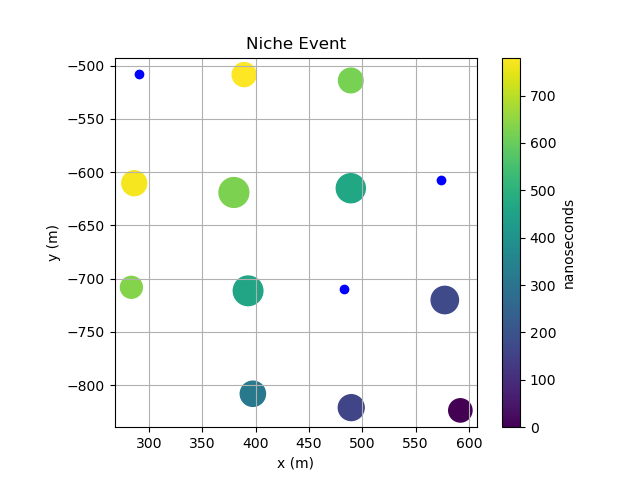

In [18]:
fit_nfits = pe.gen_nfits_from_event(fit_ev)
plot_event(tyro(fit_nfits))

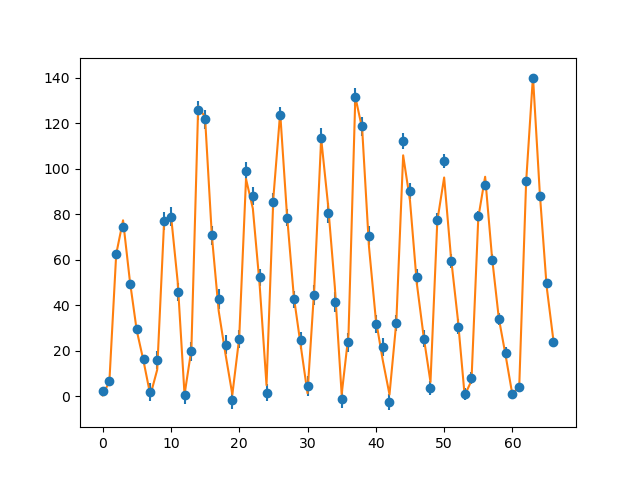

In [19]:
# at = AllTunka(real_nfits, BasicParams, cfg)
plt.figure()
plt.errorbar(np.arange(len(at.real_values)),at.real_values,yerr=at.error, fmt="o")
plt.plot(at.get_output(fitpars))
# plt.semilogy()

In [20]:
pars[-1] = 90
at.chi2(pars)/m.ndof

590.1913143909635

In [21]:
pars

[500.0,
 2000000.0,
 0.6981317007977318,
 5.497787143782138,
 450.0,
 -660.0,
 -29,
 0,
 70,
 90]